In [27]:
#路径管理/全局变量
import os
import sys

# 设置为项目根目录（包含 data, pipline 等文件夹的目录）
project_root = os.path.abspath("..")
os.chdir(project_root)
sys.path.append(project_root)
from utils.config import KEYWORDS
from utils.path_helper import get_data_path

#基础模块
import numpy as np
import pandas as pd

#清洗函数，特征工程函数导入
from pipline.pipline import pipeline_house_data
from features_wlh.features_wlh import add_selected_features

#导入训练函数
from model.train_model import train_model
#选择训练函数，自己去调整
from sklearn.ensemble import RandomForestRegressor
#训练集划分(已经在train_model里面做过,导入只是告诉你已经做完了)
from sklearn.model_selection import train_test_split
#特征值相关性检验,共线性检验
from features_wlh.feature_analysis import plot_feature_correlation
from features_wlh.feature_vif_validation import check_multicollinearity
#评估
from model.evaluate import evaluate_model

In [28]:
# 读取数据
df = pd.read_csv(get_data_path("house_prices.csv"))
# 清洗数据
df_cleaned = pipeline_house_data(df, keywords=KEYWORDS)

Fundenmental Analysis

Analysis with picture and Visualization

Project  of Features and Validation

In [34]:
My_features = ["Bathroom","Furnishing_giving","floor_level_normalize","has_amenities",
                                    "has_green_space","has_proximity","is_affordable","is_basement","is_deal",
                                    "is_gated","is_ground","is_luxury","is_marketing_strong","is_new","is_prime_location",
                                    "is_resale","is_spacious","is_well_planned","location_rank","max_floor","normal_Carpet_Area",
                                    "normal_price","ownership_score","floor_area_combo","location_comfort_combo", #有点用但不多
                                    "location_ownership_combo", "facing_height_combo", "area_furnishing_combo"] #一个示例，训练的时候根据特征分析自己去选

df_cleaned_features = add_selected_features(df_cleaned, features_to_use = My_features)

d:\Anaconda3\envs\python\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


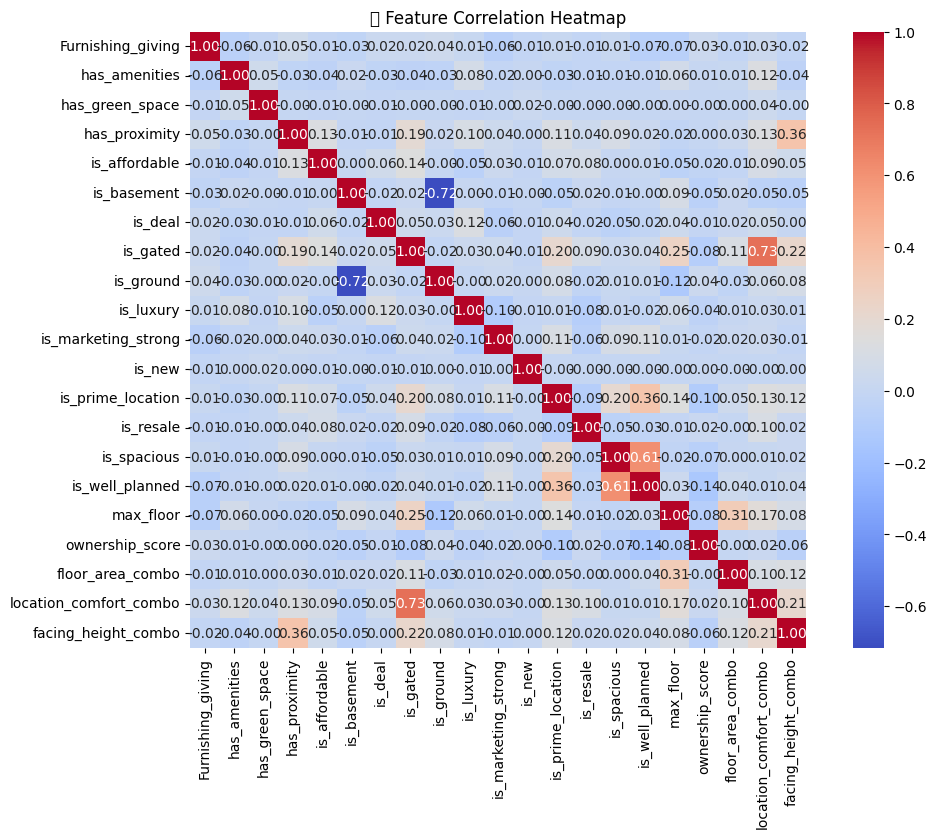

✅ 没有检测到高度相关的特征对。


d:\Anaconda3\envs\python\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🧪 方差膨胀因子（VIF）检测结果：
                     feature        VIF
0                      const        inf
2          Price (in rupees)        inf
3                Carpet Area        inf
17          location_encoded  71.789355
26        col_Bathroom_score        inf
30                  Bathroom        inf
32             location_rank  51.339036
33            location_level  34.143651
34        normal_Carpet_Area        inf
35              normal_price        inf
38  location_ownership_combo  50.193655
40     area_furnishing_combo   5.554788


In [35]:
plot_feature_correlation(df_cleaned_features, features = My_features, threshold=0.85)
vif_result = check_multicollinearity(df_cleaned_features, threshold=5)

Train Model (去train_model.py里面调整参数,调整模型选择，notebook仅用于使用grid找参数)

In [36]:
after_trained_model, X_test, y_test = train_model(df_cleaned_features, df_cleaned, features_to_use = My_features) 

✅ 模型训练完成，保存到： models_saved/rf_model.pkl


Evaulate Model & Parameter optimization

In [37]:
evaluate_model(after_trained_model, X_test, y_test)



MAE: 2571198.38
RMSE: 76038498.95
R² Score: 0.0098


{'MAE': 2571198.381541797,
 'RMSE': 76038498.95335995,
 'R2': 0.009842770007104318}